In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit, GroupKFold, cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, lasso_path
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor

from xgboost import XGBRegressor

pd.options.mode.chained_assignment = None  # default='warn'
%load_ext autoreload
%autoreload 2

In [2]:
from utils import REPO_PATH, DATA_PATH, DATA_CLEAN_PATH
from utils import set_plt_settings
from train_functions import scoring, run_cv

set_plt_settings()

## Make analytic datasets

In [3]:
df = pd.read_csv(DATA_CLEAN_PATH / 'analysis_df.csv')

X = df.loc[:, [col for col in df.columns if col.startswith(('ndvi', 'lst'))]]
y = (df.total / df.area_km).to_numpy() # short tons per km^2
g_state = df.statefp

## Regress on all features

In [4]:
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
scaler.fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)

In [5]:
X_lm = sm.add_constant(X_scaled, prepend=False)
lm = sm.OLS(endog=y, exog=X_lm, hasconst=True)
res = lm.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     1152.
Date:                Sat, 28 May 2022   Prob (F-statistic):               0.00
Time:                        11:06:04   Log-Likelihood:                -73838.
No. Observations:                8199   AIC:                         1.477e+05
Df Residuals:                    8170   BIC:                         1.479e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
lst_consec_mbm_max_mean 

## Run lasso to identify mvp features

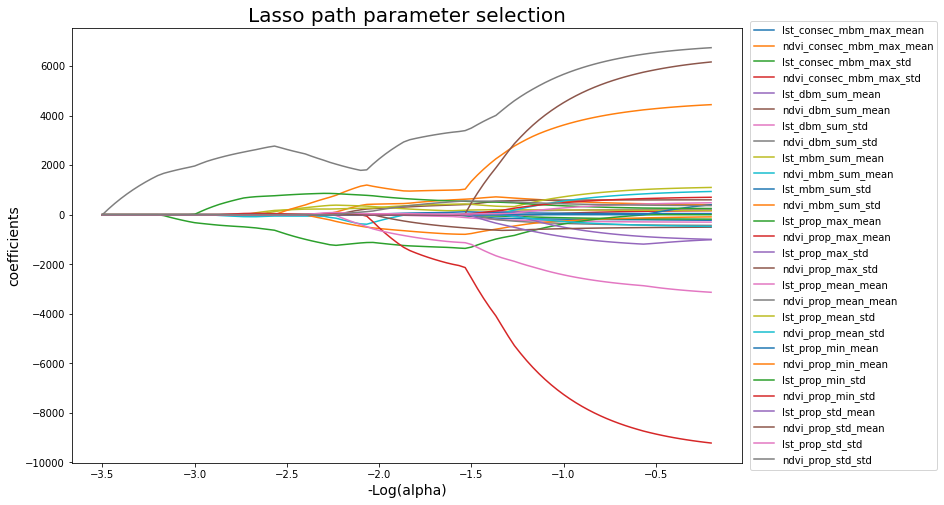

In [6]:
eps = 5e-4  # the smaller it is the longer is the path
alphas_lasso, coefs_lasso, _ = lasso_path(X_scaled, y, eps=eps)
# Display results
fig, ax = plt.subplots(figsize=(12, 8))
varnames = X_scaled.columns
neg_log_alphas_lasso = -np.log10(alphas_lasso)
for coef_l, v in zip(coefs_lasso, varnames):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, label=v)

plt.xlabel("-Log(alpha)")
plt.ylabel("coefficients")
plt.title("Lasso path parameter selection")
plt.legend(loc='right', bbox_to_anchor=(1.3, .5))
plt.axis("tight")
plt.axvline(x=0, color='r', linestyle='--')
plt.show()

In [7]:
# can we improve regression by selecting these top variables?
a_step = 20
top_n = 8
keepcols = varnames[np.argsort(np.abs(coefs_lasso[:, a_step]))[0:top_n]].to_numpy()
print(f'{top_n} most significant variables at alpha {neg_log_alphas_lasso[a_step]}:\n', keepcols)

8 most significant variables at alpha -2.8337068745277807:
 ['lst_consec_mbm_max_mean' 'ndvi_prop_std_mean' 'lst_prop_std_mean'
 'ndvi_prop_min_mean' 'lst_prop_min_mean' 'ndvi_prop_mean_std'
 'lst_prop_mean_std' 'lst_prop_mean_mean']


In [8]:
X_scaled_lasso = X_scaled.loc[:, keepcols]
X_lm = sm.add_constant(X_scaled_lasso, prepend=False)
lm = sm.OLS(endog=y, exog=X_lm, hasconst=True)
res = lm.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     2080.
Date:                Sat, 28 May 2022   Prob (F-statistic):               0.00
Time:                        11:06:10   Log-Likelihood:                -75846.
No. Observations:                8199   AIC:                         1.517e+05
Df Residuals:                    8190   BIC:                         1.518e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
lst_consec_mbm_max_mean   

## Examine principal components

## Cross validate contending models

In [9]:
# dummy regressor
params={}
cv_mean, cv_mean_min = run_cv(X=X_scaled, y=y, estimator=DummyRegressor(), params=params, scoring=scoring)
cv_mean_min

model                          DummyRegressor()
params                                       {}
neg_root_mean_squared_error        -4382.952289
mean_test_r_squared                   -0.001913
Name: 0, dtype: object

In [10]:
# linear regression
params={}
cv_lm, cv_lm_min = run_cv(X=X_scaled, y=y, estimator=LinearRegression(), params=params, scoring=scoring)
cv_lm_min

model                          LinearRegression()
params                                         {}
neg_root_mean_squared_error            -1989.4228
mean_test_r_squared                      0.793126
Name: 0, dtype: object

In [12]:
# lasso regression
params={'alpha':[j*(10**i) for i in range(1,3) for j in range(1, 9)]}
cv_lasso, cv_lasso_min = run_cv(X=X_scaled, y=y, estimator=Lasso(), params=params, scoring=scoring)
cv_lasso_min

model                                Lasso()
params                         {'alpha': 10}
neg_root_mean_squared_error     -2013.503508
mean_test_r_squared                 0.788329
Name: 0, dtype: object

In [13]:
# decision tree regression
params={'min_samples_leaf': [1, 5, 10, 50, 100], 'max_depth': [None, 100, 50, 10, 5]}
cv_dt, cv_dt_min = run_cv(X=X_scaled, y=y, estimator=DecisionTreeRegressor(), params=params, scoring=scoring)
cv_dt_min

model                                            DecisionTreeRegressor()
params                         {'max_depth': 10, 'min_samples_leaf': 10}
neg_root_mean_squared_error                                 -1709.201305
mean_test_r_squared                                             0.847164
Name: 17, dtype: object

In [15]:
# random forest regression
params={'min_samples_leaf': [1, 5, 10, 50, 100], 'max_depth': [None, 100, 50, 10, 5]}
# params={'min_samples_leaf': [3, 5, 7], 'max_depth': [200, 150, 100]} #7, 100
# params={'min_samples_leaf': [6, 7, 8], 'max_depth': [90, 100, 110]}
cv_rf, cv_rf_min = run_cv(X=X_scaled, y=y, estimator=RandomForestRegressor(), params=params, scoring=scoring)
cv_rf_min

KeyboardInterrupt: 

In [16]:
# xgboost regression
params={'reg_alpha':[.01, .1, 1, 10, 100], 'reg_lambda':[0.1, .1, 1, 10, 100],
        'tree_method':['approx', 'hist']}
cv_xgb, cv_xgb_min = run_cv(X=X_scaled, y=y, estimator=XGBRegressor(objective="reg:squarederror"), params=params, scoring=scoring)
cv_xgb_min

KeyboardInterrupt: 

In [ ]:
cv = pd.DataFrame((cv_mean_min, cv_lm_min, cv_lasso_min, cv_dt_min, cv_rf_min, cv_xgb_min))
cv